In [182]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from comet_ml import Experiment
import numpy as np
import scipy.spatial
import pandas as pd
import comet_ml
import sklearn.decomposition
import matplotlib.pyplot as plt
# import keras
from sklearn import preprocessing
from sklearn.decomposition import PCA
# %matplotlib inline
# Dimension reduction and clustering libraries
import umap
# import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import pairwise_distances,mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from utils.readProfiles import readMergedProfiles
from utils.pred_models import *
from utils.saveAsNewSheetToExistingFile import saveAsNewSheetToExistingFile

# from utils import networksEvol, tsne, readProfiles
import umap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### In this notebook we test how combinting two data modalities will improve preformance of the following tasks:
    1 - MOA prediction
    2 - ?

## MoA Prediction:
- Data Fusion Methods:
    - Early Fusion: simple concatenation
    - Late Fusion: desision probabilty average
    - SNF
    - CCA

## Datasets and MoA annotations:

#### LINCS
- Full Set:
    - 568 unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
- Filt Set:
    - 284 unique multi-label MoAs (74 of these labels have more than 1 moa label)
    


#### CDRP-bio
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    
    
#### CDRP
- Full Set:
    - xx unique multi-label MoAs (74 of these labels have more than 1 moa label)
    
- Filt Set:
    - xx unique multi-label MoAs (163 of these labels have more than 1 moa label)
    


### Paths

In [3]:
procProf_dir='/home/ubuntu/datasetsbucket/Rosetta-GE-CP/'
# procProf_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/'
metadata_dir='/home/ubuntu/bucket/projects/2018_04_20_Rosetta/workspace/metadata/'
results_dir='./results/'

### Read GE and CP profiles 

In [183]:
################################################
# dataset options: 'CDRP' , 'LUAD', 'TAORF', 'LINCS', 'CDRP-bio'
dataset='LINCS'


################################################
# CP Profile Type options: 'augmented' , 'normalized', 'normalized_variable_selected'
profileType='normalized_variable_selected'
profTypeAbbrev=''.join([s[0] for s in profileType.split('_')])

################################################
# filtering to compounds which have high replicates for both GE and CP datasets
highRepOverlapEnabled=0


################################################
pertColName='PERT'
profileLevel='treatment'; #'replicate'  or  'treatment'
if highRepOverlapEnabled:
    f='filt'
else:
    f=''

nRep=1
mergProf_repLevel,mergProf_treatLevel,cp_features,l1k_features=\
readMergedProfiles(procProf_dir,dataset,profileType,profileLevel,nRep,highRepOverlapEnabled);

moa_col='Metadata_MoA'

##################################
if dataset=='LINCS':
    mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
    mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
    
    mergProf_treatLevel['Compounds']=mergProf_treatLevel['PERT'].str[0:13]


# mergProf_repLevel,mergProf_treatLevel,l1k_features,cp_features,pertColName=readMergedProfiles(dataset,profileType,nRep)
# cp_features,l1k_features=cp_features.tolist(),l1k_features.tolist()
# mergProf_repLevel['Compounds']=mergProf_repLevel['PERT'].str[0:13]

if profileLevel=='replicate':
    l1k=mergProf_repLevel[[pertColName]+l1k_features]
    cp=mergProf_repLevel[[pertColName]+cp_features]
elif profileLevel=='treatment':
    l1k=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+l1k_features]
    cp=mergProf_treatLevel[[pertColName,'Compounds',moa_col]+cp_features]


scaler_ge = preprocessing.StandardScaler()
scaler_cp = preprocessing.StandardScaler()
l1k_scaled=l1k.copy()
l1k_scaled[l1k_features] = scaler_ge.fit_transform(l1k[l1k_features].values)
cp_scaled=cp.copy()
cp_scaled[cp_features] = scaler_cp.fit_transform(cp[cp_features].values.astype('float64'))


if 1:
    cp_scaled[cp_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(cp_scaled[cp_features].values)   
    l1k_scaled[l1k_features] =preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(l1k_scaled[l1k_features].values)           

    
merged_scaled=pd.concat([cp_scaled, l1k_scaled], axis=1)
merged_scaled = merged_scaled.loc[:,~merged_scaled.columns.duplicated()]    
merged_scaled['Compounds']=merged_scaled['PERT'].str[0:13]



#################### keep MOAs with more than "nSamplesMOA" compounds in their class

nSamplesMOA=1

nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Compounds']).sample(1).groupby([moa_col]).size().\
reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)


nSamplesforEachMOAclass2=mergProf_treatLevel.groupby([moa_col]).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)

listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>nSamplesMOA][moa_col].tolist()
le = preprocessing.LabelEncoder()
le.fit(listOfSelectedMoAs)

IDs4filteredMOAs=mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)][pertColName].tolist()

filteredMOAs=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
data4eval=[[cp_scaled[cp_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True),cp_features],\
           [l1k_scaled[l1k_scaled[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True),l1k_features],\
           [filteredMOAs,cp_features+l1k_features]]

filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())


/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (18,19,1249,1250) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


LINCS: Replicate Level Shapes (nSamples x nFeatures): cp:  52223 , 119 ,  l1k:  27837 , 978
l1k n of rep:  3.0
cp n of rep:  5.0
Treatment Level Shapes (nSamples x nFeatures+metadata): (9395, 122) (8370, 980) Merged Profiles Shape: (6985, 1101)


In [69]:
# len([u.split('|') for u in unq if '|' in u])

In [184]:
mergProf_treatLevel[moa_col]=mergProf_treatLevel['Metadata_moa']
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),moa_col]=\
mergProf_treatLevel.loc[mergProf_treatLevel['Metadata_moa'].isnull(),'moa'].str.lower()
mergProf_treatLevel['Metadata_MoA'].unique().shape

(568,)

#### Number of Classes with more than one label

<IPython.core.display.Javascript object>


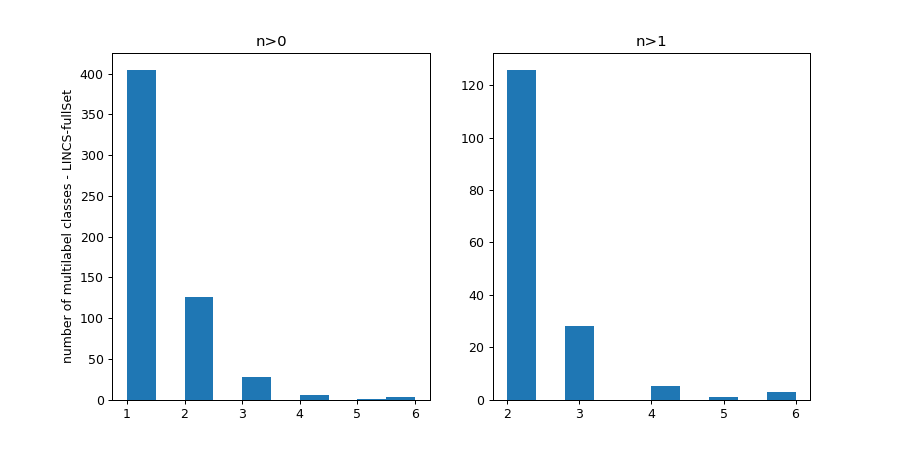

In [185]:
unq=mergProf_treatLevel['Metadata_MoA'].unique().tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');
axes[0].set_ylabel('number of multilabel classes - LINCS-fullSet');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel classes');

#### Number of Samples with more than one label

<IPython.core.display.Javascript object>


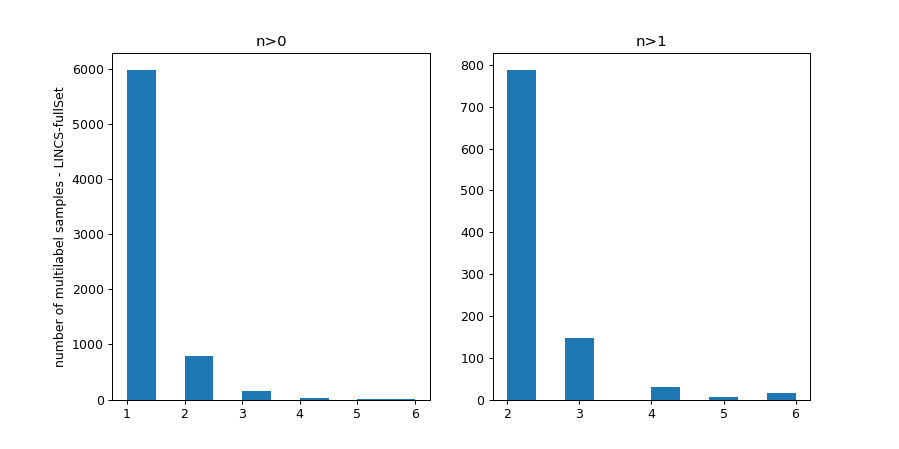

In [186]:
unq=mergProf_treatLevel['Metadata_MoA'].tolist()
# n_multi_l=[len(u.split('|')) for u in unq if '|' in u]

fig, axes = plt.subplots(1,2,figsize=(10,5))

axes[0].hist([len(u.split('|')) for u in unq]);
axes[0].set_title('n>0');axes[0].set_ylabel('number of multilabel samples - LINCS-fullSet');

axes[1].hist([len(u.split('|')) for u in unq if '|' in u]);
axes[1].set_title('n>1');#axes[1].set_ylabel('number of multilabel samples');

In [32]:


mergProf_treatLevel.columns[mergProf_treatLevel.columns.str.contains('moa')]
# list(set(mergProf_treatLevel.columns.tolist())-set(cp_features))

Index(['Metadata_moa', 'Metadata_alternative_moa', 'moa'], dtype='object')

In [75]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
1,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
2,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
3,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
4,insulin sensitizer|PPAR receptor partial agonist,NaN,Insulin sensitizer|PPAR receptor partial agonist,insulin sensitizer|PPAR receptor partial agonist
...,...,...,...,...
6980,NaN,NaN,Potassium channel activator,potassium channel activator
6981,NaN,NaN,Potassium channel activator,potassium channel activator
6982,NaN,NaN,Potassium channel activator,potassium channel activator
6983,NaN,NaN,Potassium channel activator,potassium channel activator


In [31]:
mergProf_treatLevel[['Metadata_moa', 'Metadata_alternative_moa', 'moa',moa_col]]

,Metadata_moa,Metadata_alternative_moa,moa,Metadata_MoA
0,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
1,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
2,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
3,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
4,HSP inhibitor,NaN,HSP inhibitor,HSP inhibitor
...,...,...,...,...
1136,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1137,potassium channel activator,NaN,Potassium channel activator,potassium channel activator
1138,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...,NaN,Src inhibitor|Abl kinase inhibitor|Bcr-Abl kin...,Abl kinase inhibitor|Bcr-Abl kinase inhibitor|...
1139,NaN,NaN,Dopamine receptor antagonist,Dopamine receptor antagonist


In [21]:
mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

134                  Rho associated kinase inhibitor
135                  Rho associated kinase inhibitor
136                  Rho associated kinase inhibitor
137                  Rho associated kinase inhibitor
147                                   MTOR inhibitor
148                                   MTOR inhibitor
149                                   MTOR inhibitor
150                                   MTOR inhibitor
151                                   MTOR inhibitor
170                  Glucocorticoid receptor agonist
171                  Glucocorticoid receptor agonist
172                  Glucocorticoid receptor agonist
173                  Glucocorticoid receptor agonist
174                  Glucocorticoid receptor agonist
228     Methylmalonyl CoA mutase stimulant|Vitamin B
252                        Potassium channel blocker
394                  Benzodiazepine receptor agonist
465                  Rho associated kinase inhibitor
466                  Rho associated kinase inh

In [63]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()]['moa']

In [78]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_moa'].isnull()].shape

(195, 1103)

In [40]:
# mergProf_treatLevel[mergProf_treatLevel['Metadata_MoA'].isnull()].shape

<ipython-input-7-427f03c47b5a>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp['Compounds']=cp['PERT'].str[0:13]
<ipython-input-7-427f03c47b5a>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l1k['Compounds']=l1k['PERT'].str[0:13]


In [48]:
# cp['Compounds'],cp['PERT']
pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])

,Metadata_MoA,size_x,size_y
0,adrenergic receptor antagonist,33,165
1,phosphodiesterase inhibitor,32,159
2,cyclooxygenase inhibitor,31,154
3,histamine receptor antagonist,24,120
4,acetylcholine receptor antagonist,21,105
...,...,...,...
563,apoptosis stimulant,1,5
564,antiviral|RNA synthesis inhibitor,1,5
565,antiviral,1,5
566,antitumor agent|ribonucleotide reductase inhib...,1,5


In [56]:
# pd.concat([nSamplesforEachMOAclass,nSamplesforEachMOAclass2])
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


<ipython-input-10-683e67e481f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass_['h']='n-compounds'
<ipython-input-10-683e67e481f8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nSamplesforEachMOAclass2_['h']='n-samples'


<IPython.core.display.Javascript object>


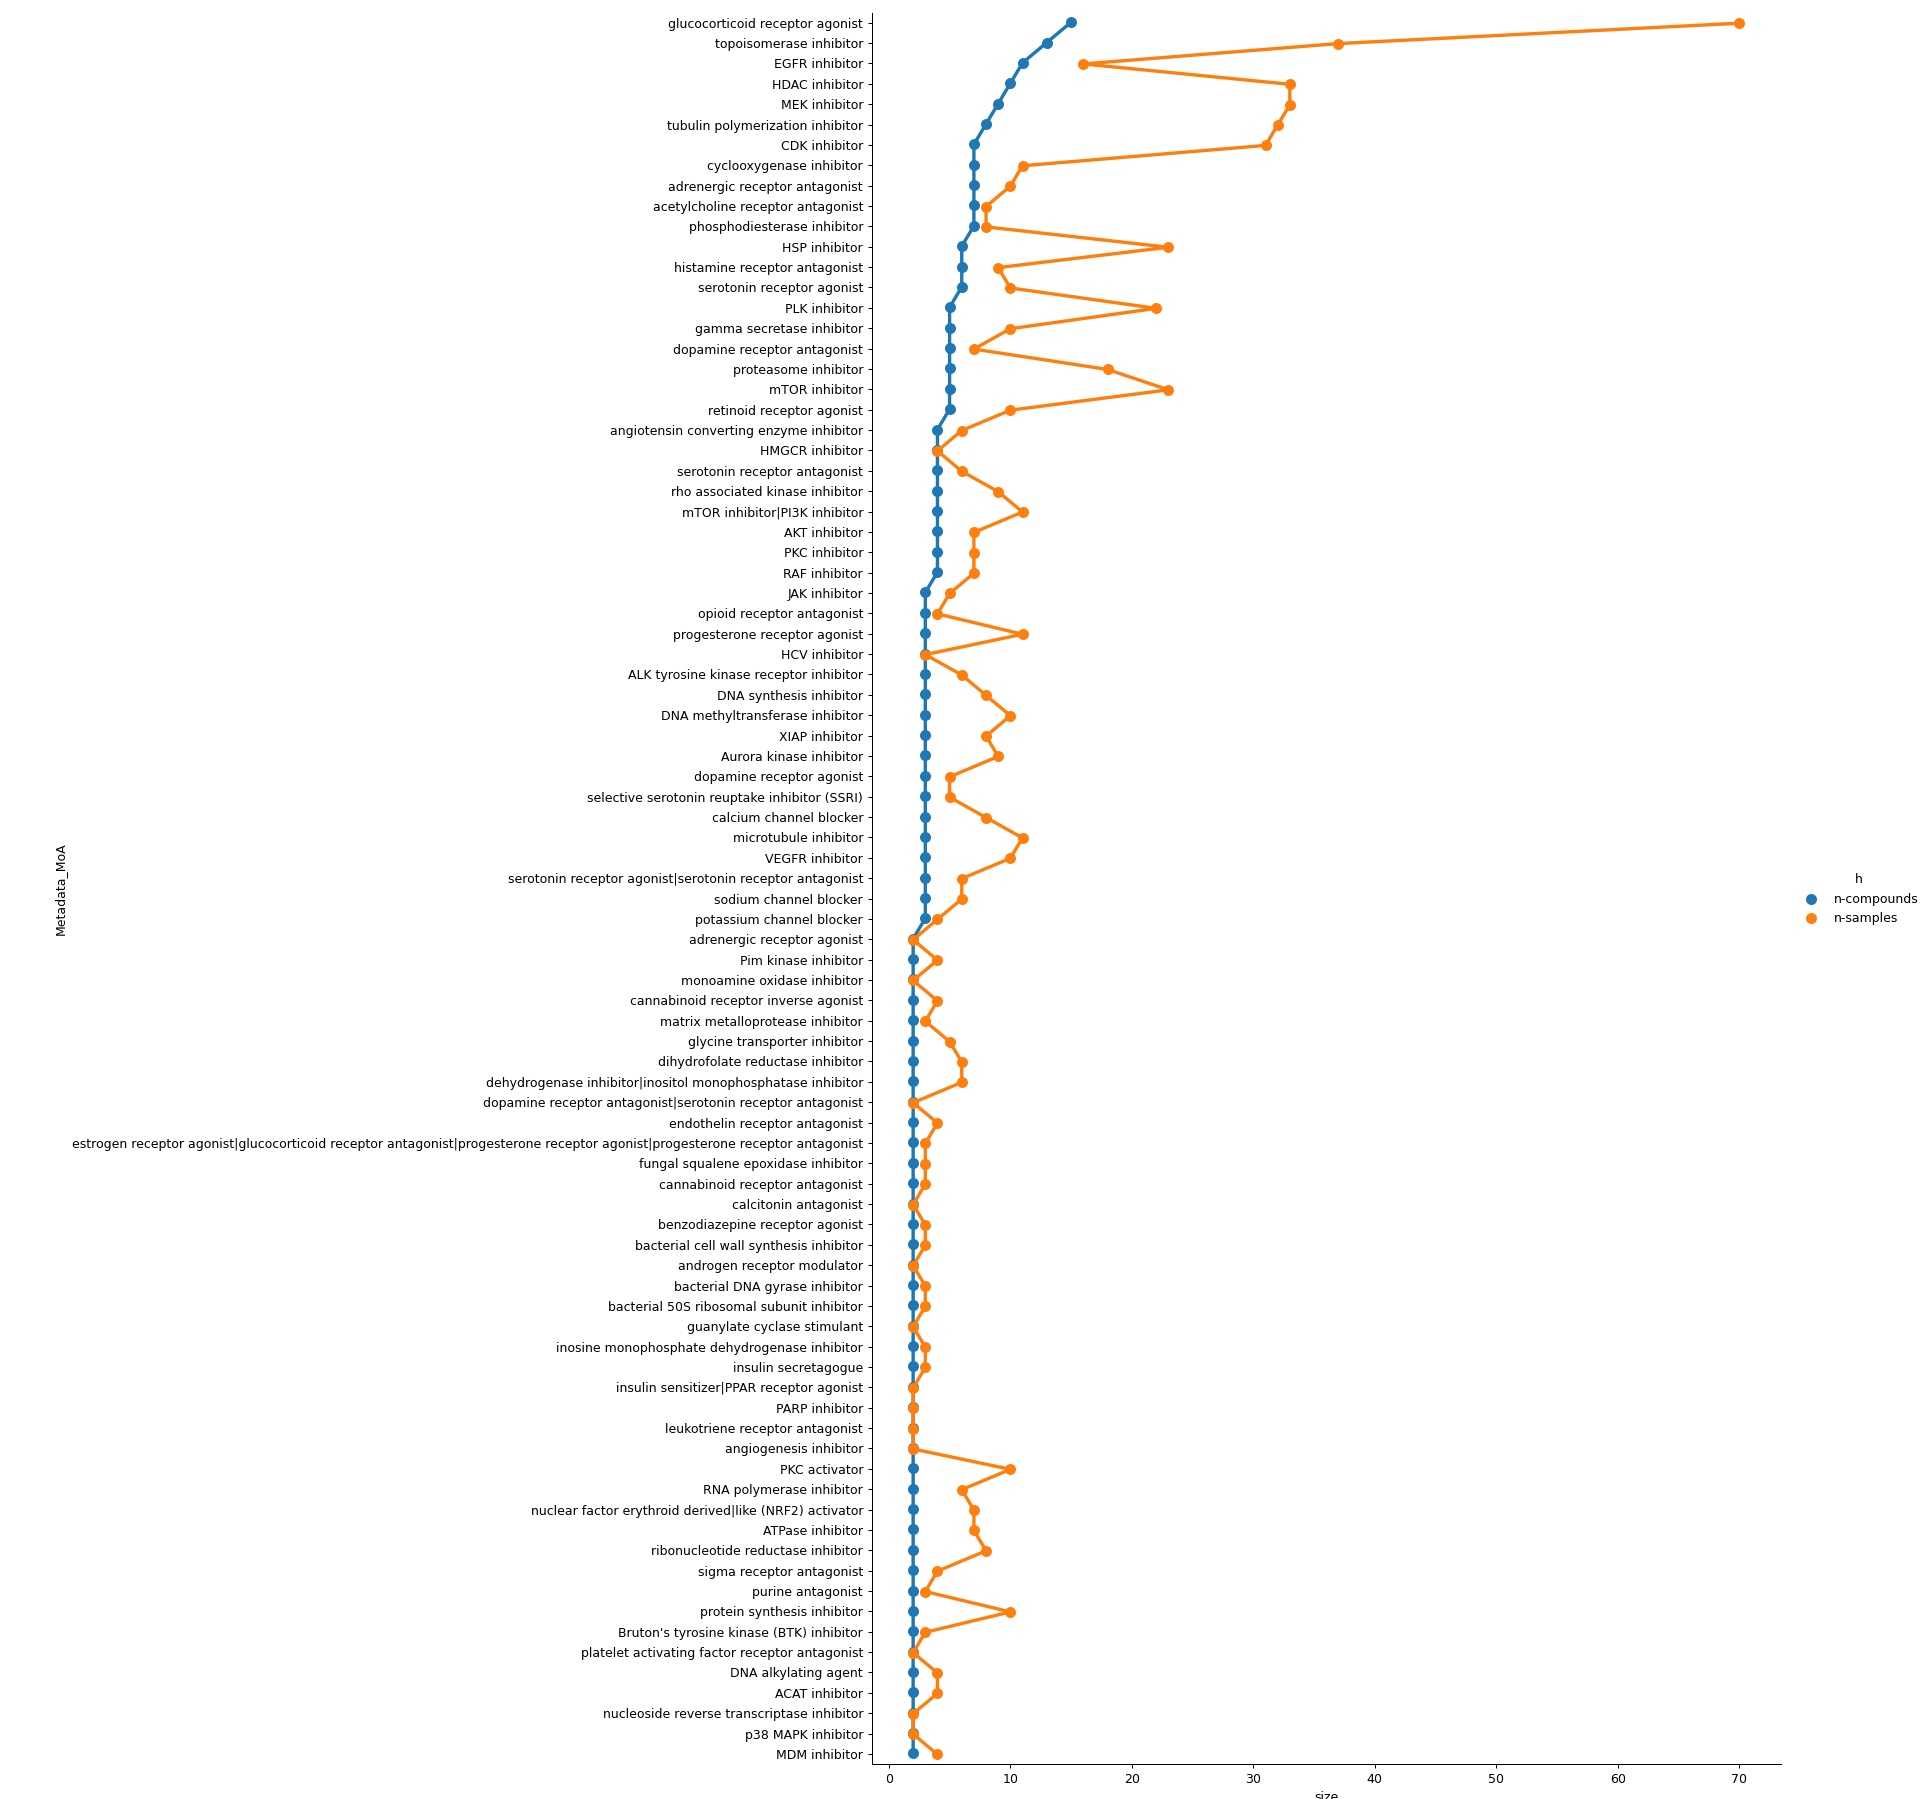

In [10]:
# plt.figure()
# fig, axes = plt.subplots(figsize=(20,5))
# nSamplesforEachMOAclass3=pd.merge(nSamplesforEachMOAclass,nSamplesforEachMOAclass2,how='inner',on=[moa_col])
nSamplesforEachMOAclass_=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]
nSamplesforEachMOAclass2_=nSamplesforEachMOAclass2[nSamplesforEachMOAclass2[moa_col].isin(nSamplesforEachMOAclass_[moa_col].tolist())]
nSamplesforEachMOAclass_['h']='n-compounds'
nSamplesforEachMOAclass2_['h']='n-samples'

nSamplesforEachMOAclass3=pd.concat([nSamplesforEachMOAclass_,nSamplesforEachMOAclass2_])

sns.catplot(x="size",y=moa_col, data=nSamplesforEachMOAclass3[nSamplesforEachMOAclass3['size']>1],\
            orient="h", height=20, aspect=1,hue='h',
                kind="point", dodge=True, cut=0, bw=.2)
# fig.tight_layout()

In [58]:
# repp_df
nSamplesforEachMOAclass2[meta_col]

NameError: name 'meta_col' is not defined

In [139]:
# mergProf_treatLevel.groupby(['moa']).size().reset_index().rename(columns={0:'nrep'}).sort_values(by='nrep')
moa_col='moa'

In [292]:
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

191


In [225]:
# mergProf_treatLevel['Metadata_moa']=mergProf_treatLevel['Metadata_moa'].str.lower()
nSamplesforEachMOAclass=mergProf_treatLevel.groupby(['Metadata_moa']).size().reset_index().rename(columns={0:'size'}).sort_values(by=['size'],ascending=False).reset_index(drop=True)
listOfSelectedMoAs=nSamplesforEachMOAclass[nSamplesforEachMOAclass['size']>1]['Metadata_moa'].tolist()
print(len(listOfSelectedMoAs))

14


In [226]:
listOfSelectedMoAs

['ATPase inhibitor',
 'tubulin polymerization inhibitor',
 'CDK inhibitor',
 'retinoid receptor agonist',
 'calcium channel blocker',
 'dopamine receptor antagonist',
 'protein synthesis inhibitor',
 'mitochondrial oxidative phosphorylation uncoupler',
 'HDAC inhibitor|cell cycle inhibitor',
 'HDAC inhibitor',
 'protein tyrosine kinase inhibitor|tyrosine kinase inhibitor',
 'EGFR inhibitor',
 'p38 MAPK inhibitor',
 'topoisomerase inhibitor']

In [46]:
nSamplesforEachMOAclass

,Metadata_MoA,size
0,adrenergic receptor antagonist,33
1,phosphodiesterase inhibitor,32
2,cyclooxygenase inhibitor,31
3,histamine receptor antagonist,24
4,acetylcholine receptor antagonist,21
...,...,...
563,apoptosis stimulant,1
564,antiviral|RNA synthesis inhibitor,1
565,antiviral,1
566,antitumor agent|ribonucleotide reductase inhib...,1


In [1]:
# IDs4filteredMOAs

In [38]:
# nSamplesforEachMOAclass
# IDs4filteredMOAs
# pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])
filteredMOAs.loc[test_index,'Compounds'].unique()[0]

'BRD-A03506276'

### MoA prediction using each dataset and early and late fusion of datasets

In [ ]:
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut

# domXdata=merged_scaled.copy();
# domXfeats=data4eval[r][1]
# outdim_size=40

# filteredMOAs=domXdata[domXdata[pertColName].isin(IDs4filteredMOAs)].reset_index(drop=True)
# filteredMOAs['Metadata_moa_num']=le.transform(filteredMOAs[moa_col].tolist())

moa_pred_res=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion',\
                                                                          'Late Fusion','Metadata_moa_num'])

# n_of_random_sel=20
# n_of_random_sel=50
# n_folds=5
# acc_array_fullSet2_cdrp=np.zeros((n_of_random_sel,4));
# acc_array_filtSet2_cdrp=np.zeros((n_of_random_sel,4));
# for i in range(n_of_random_sel):

#     split_obj=GroupKFold(n_splits=k)
# #     split_obj = LeaveOneGroupOut()    
#     # Perform k-fold cross validation
#     scores = cross_val_score(clf, X, y, groups=group_labels,cv=split_obj,n_jobs=n_j)

# kf = KFold(n_splits=n_folds,random_state=1,shuffle=True)
# gkf=GroupKFold(n_splits=n_folds)

logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
    print('rand ',i)
    i+=1
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")

    probs=[]
    for n,dt_modality,col in zip([0,1,2],data4eval,['CP','GE','Early Fusion']):
        
        data_m=dt_modality[0]   

        dt_train=data_m.loc[train_index,dt_modality[1]].values;
        dt_test=data_m.loc[test_index,dt_modality[1]].values; 
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr = GaussianNB()
#         model_tr = ComplementNB()

#         model_tr = RandomForestClassifier(n_estimators=10)
        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=1,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
#         accc=model_tr.score(dt_test,labels_test)
#         print(model_tr.predict(dt_test))
#         accc=f1_score(labels_test,model_tr.predict(dt_test), average='weighted')        
        moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
#         moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
        probs.append(model_tr.predict_proba(dt_test))

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]
    moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    labels_lateFusion
    moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
    labels_test
#     f1_score(labels_test,labels_lateFusion, average='weighted')*100
#     accuracy_score(labels_test,labels_lateFusion)*100

moa_pred_res['Metadata_moa_num']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    
print(moa_pred_res.mean())


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f+'-predictions-RF')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

rand  0
rand  1
rand  2
rand  3
rand  4
rand  5
rand  6
rand  7
rand  8
rand  9
rand  10
rand  11
rand  12
rand  13
rand  14
rand  15
rand  16
rand  17
rand  18
rand  19
rand  20
rand  21
rand  22
rand  23
rand  24
rand  25
rand  26
rand  27
rand  28
rand  29
rand  30
rand  31
rand  32
rand  33
rand  34
rand  35
rand  36
rand  37
rand  38
rand  39
rand  40
rand  41
rand  42
rand  43
rand  44
rand  45
rand  46
rand  47
rand  48
rand  49
rand  50
rand  51
rand  52
rand  53
rand  54
rand  55
rand  56
rand  57
rand  58
rand  59
rand  60
rand  61
rand  62
rand  63
rand  64
rand  65
rand  66
rand  67
rand  68
rand  69
rand  70
rand  71
rand  72
rand  73
rand  74
rand  75
rand  76
rand  77
rand  78
rand  79
rand  80
rand  81
rand  82
rand  83
rand  84
rand  85
rand  86
rand  87
rand  88
rand  89
rand  90
rand  91
rand  92
rand  93
rand  94
rand  95
rand  96
rand  97
rand  98
rand  99
rand  100
rand  101
rand  102
rand  103
rand  104
rand  105
rand  106
rand  107
rand  108
rand  109
rand  110


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


rand  325
rand  326
rand  327
rand  328
rand  329
rand  330
rand  331
rand  332
rand  333
rand  334
rand  335
rand  336
rand  337
rand  338
rand  339
rand  340
rand  341
rand  342
rand  343
rand  344
rand  345
rand  346
rand  347
rand  348
rand  349
rand  350
rand  351
rand  352
rand  353
rand  354
rand  355
rand  356
rand  357
rand  358
rand  359
rand  360
rand  361
rand  362
rand  363
rand  364
rand  365
rand  366
rand  367
rand  368
rand  369
rand  370
rand  371
rand  372
rand  373
rand  374
rand  375
rand  376
rand  377
rand  378
rand  379
rand  380
rand  381
rand  382
rand  383
rand  384
rand  385
rand  386
rand  387
rand  388
rand  389
rand  390
rand  391
rand  392
rand  393
rand  394
rand  395
rand  396
rand  397
rand  398
rand  399
rand  400
rand  401
rand  402
rand  403
rand  404
rand  405
rand  406
rand  407
rand  408
rand  409
rand  410
rand  411
rand  412
rand  413
rand  414
rand  415
rand  416
rand  417
rand  418
rand  419
rand  420
rand  421
rand  422
rand  423
rand  424


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


rand  434
rand  435
rand  436
rand  437
rand  438
rand  439
rand  440
rand  441
rand  442
rand  443
rand  444
rand  445
rand  446
rand  447
rand  448
rand  449
rand  450
rand  451
rand  452
rand  453
rand  454
rand  455
rand  456
rand  457
rand  458
rand  459
rand  460
rand  461
rand  462
rand  463
rand  464
rand  465
rand  466
rand  467
rand  468
rand  469
rand  470
rand  471
rand  472
rand  473
rand  474
rand  475
rand  476
rand  477
rand  478
rand  479
rand  480
rand  481
rand  482
rand  483
rand  484
rand  485
rand  486
rand  487
rand  488
rand  489
rand  490
rand  491
rand  492
rand  493
rand  494
rand  495
rand  496
rand  497
rand  498
rand  499
rand  500
rand  501
rand  502
rand  503
rand  504
rand  505
rand  506
rand  507
rand  508
rand  509
rand  510
rand  511
rand  512
rand  513
rand  514
rand  515
rand  516
rand  517
rand  518
rand  519
rand  520
rand  521
rand  522
rand  523
rand  524
rand  525
rand  526
rand  527
rand  528
rand  529
rand  530
rand  531
rand  532
rand  533


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


rand  548
rand  549
rand  550
rand  551
rand  552
rand  553
rand  554
rand  555
rand  556
rand  557
rand  558
rand  559
rand  560
rand  561
rand  562
rand  563
rand  564
rand  565
rand  566
rand  567
rand  568
rand  569
rand  570
rand  571
rand  572
rand  573
rand  574
rand  575
rand  576
rand  577
rand  578
rand  579
rand  580
rand  581
rand  582
rand  583
rand  584
rand  585
rand  586
rand  587
rand  588
rand  589
rand  590
rand  591
rand  592
rand  593
rand  594
rand  595
rand  596
rand  597
rand  598
rand  599
rand  600
rand  601
rand  602
rand  603
rand  604
rand  605
rand  606
rand  607
rand  608
rand  609
rand  610
rand  611
rand  612
rand  613
rand  614
rand  615
rand  616
rand  617
rand  618
rand  619
rand  620
rand  621
rand  622
rand  623
rand  624
rand  625
rand  626
rand  627
rand  628
rand  629
rand  630
rand  631
rand  632
rand  633
rand  634
rand  635
rand  636
rand  637
rand  638
rand  639
rand  640
rand  641
rand  642
rand  643
rand  644
rand  645
rand  646
rand  647


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


rand  658
rand  659
rand  660
rand  661
rand  662
rand  663
rand  664
rand  665
rand  666
rand  667
rand  668
rand  669
rand  670
rand  671
rand  672
rand  673
rand  674
rand  675
rand  676
rand  677
rand  678
rand  679
rand  680
rand  681
rand  682
rand  683
rand  684
rand  685
rand  686
rand  687
rand  688
rand  689
rand  690
rand  691
rand  692
rand  693
rand  694
rand  695
rand  696
rand  697
rand  699


/home/ubuntu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


rand  700
rand  701
rand  702


In [187]:
# moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]
# moa_pred_res,moa_pred_res
# filteredMOAs
# saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f+'-predictions')
# moa_pred_res['CP']
f

''

In [118]:
pd.merge(moa_pred_res,filteredMOAs[['Compounds','Metadata_moa_num']].drop_duplicates(),how='inner',on=['Compounds'])['Metadata_moa_num']

In [136]:
moa_pred_res

,CP,GE,Early Fusion,Late Fusion,Metadata_moa_num
BRD-A03506276,14,14,14,14,14
BRD-A03506276,14,6,14,14,14
BRD-A03506276,14,14,14,14,14
BRD-A03506276,62,14,14,14,14
BRD-A03506276,6,14,14,14,14
...,...,...,...,...,...
BRD-K99475619,6,84,84,84,84
BRD-K99604664,6,0,79,6,71
BRD-K99604664,60,0,1,60,71
BRD-K99604664,60,0,12,21,71


In [168]:
# moa_pred_res['Compounds']=moa_pred_res.index
# moa_pred_res
moa_pred_res['Metadata_moa_num2']=moa_pred_res.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)
f1_score(moa_pred_res['Early Fusion'].values.astype(int),moa_pred_res.Metadata_moa_num2.values, average='weighted')

0.40237308491101126

In [158]:
moa_pred_res['Metadata_moa_num2']

BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
                 ..
BRD-K99475619    84
BRD-K99604664    71
BRD-K99604664    71
BRD-K99604664    71
BRD-M80207679    45
Name: Metadata_moa_num2, Length: 752, dtype: int64

In [105]:

# moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)
moa_pred_res.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]

BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    14
BRD-A03506276    62
BRD-A03506276    62
Name: CP, dtype: object

In [97]:
# moa_pred_res['Late Fusion']=moa_pred_res['Late Fusion']*100
# print(moa_pred_res.mean())
# saveAsNewSheetToExistingFile(filename,moa_pred_res,'fuseConcat-'+dataset+'-'+profTypeAbbrev+'-'+f+'-f1')
model_tr.predict(dt_test)

array([0])

In [33]:
le.inverse_transform(model_tr.predict(dt_test)),le.inverse_transform(labels_test)

(array(['microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor', 'microtubule inhibitor',
        'microtubule inhibitor'], dtype='<U123'),
 array(['HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor', 'HSP inhibitor',
        'HSP inhibitor'], dtype='<U123'))

In [61]:
# import sklearn as skl
# skl.__version__

In [63]:
# 
# _tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(), groups=group_labels,cv=gkf)

In [62]:
# # scoring = {'recall0': make_scorer(recall_score, average = None}
# from sklearn.model_selection import cross_validate
# cross_validate(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy', return_train_score = False)

In [64]:
# gkf=GroupKFold(n_splits=5)
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='balanced_accuracy')

In [65]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1_weighted')

In [85]:
# cross_val_score(model_tr, filteredMOAs[cp_features[0:10]], filteredMOAs[moa_col].tolist(),\
#                 groups=group_labels,cv=gkf,scoring='f1')

In [66]:
# cp.shape,l1k.shape,merged_scaled.shape
# merged_scaled['PERT']
# mergProf_treatLevel[moa_col].unique()
# mergProf_treatLevel
# IDs4filteredMOAs
# mergProf_treatLevel[mergProf_treatLevel[moa_col].isin(listOfSelectedMoAs)]['Compounds'].shape
# sorted(sklearn.metrics.SCORERS.keys())

In [67]:
len(listOfSelectedMoAs),len(IDs4filteredMOAs),mergProf_treatLevel.shape

(86, 752, (1141, 1103))

In [257]:
# merged_scaled['PERT']
# listOfSelectedMoAs
# cp_features
pertColName

'PERT'

In [246]:
# import os
# os.mkdir('../../results/dataIntegration')

In [228]:
len(listOfSelectedMoAs) #filt set (n>1) CDRP

14

In [296]:
len(listOfSelectedMoAs) #full set (n>1) cdrp

191

In [533]:
len(listOfSelectedMoAs) #full set (n>3)

84

In [547]:
len(listOfSelectedMoAs) #filt set(n>3)

24

In [96]:
len(listOfSelectedMoAs) #filt set (n>1)

72

In [366]:
len(listOfSelectedMoAs) #full set (n>1)

191

In [ ]:
len(listOfSelectedMoAs) #full set (n>1)

In [437]:
cp['Compounds']=cp['PERT'].str[0:13]
l1k['Compounds']=l1k['PERT'].str[0:13]

data4eval=[[cp,cp_features],[l1k,l1k_features],[merged_scaled,cp_features+l1k_features]]

In [245]:
ls ../../results/

checkpoint                 GeneVsCPfeature/
cpCategoriesHM-LINCS.png   modelW/
cpCategoriesHM.png         modelW.data-00000-of-00001
cpFeaturesGene_ccMat.csv   modelW.index
cpFeaturesGene_ccMat.eps   RepCor/
cpFeaturesGene_ccMat.pkl   results.csv
cpFeaturesGene_ccMat.png   results-nnC.csv
cpFeaturesGene_glmMat.csv  results-replicate-nnC.csv
cpFeaturesGene_glmMat.pkl  results-Treatment12120end.csv
cpFeaturesGene_glmMat.png  results-Treatment_1t0121.csv
cpFeaturesGene_miMat.csv   results-Treatment.csv
cpFeaturesGene_miMat.pkl   results-Treatment-lin-rand.csv
cpFeaturesGene_miMat.png   SingleCPfeatPred/
dataIntegration/           SingleGenePred/


In [247]:
# DataFuseResults
# pd.to_csv('../../results/dataIntegration/fusion_res.xlsx')
res_path='../../results/dataIntegration/fusion_res.xlsx'
saveAsNewSheetToExistingFile(res_path,DataFuseResults,'logisticReg')

In [363]:
saveAsNewSheetToExistingFile(res_path,DataFuseResults_loaded,'logisticReg')

[]


In [366]:
# DataFuseResults_loaded=pd.read_excel(res_path, sheet_name=None)['logisticReg']
# DataFuseResults_loaded

In [530]:
# acc_array_fullSet=np.copy(acc_array_filtSet)

In [235]:
# filteredMOAs.loc[test_index].groupby(['Metadata_moa']).sample(1).index.values

In [37]:
filteredMOAs['Metadata_moa'].unique().shape

(179,)

In [ ]:
Clustering performance

### MoA prediction using each CCA projected dataset and early and late fusion of CCA projected datasets 

In [171]:
from sklearn.cross_decomposition import CCA
from sklearn.utils import class_weight
from sklearn.naive_bayes import GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold,LeaveOneGroupOut


outdim_size=40

moa_pred_res_cca=pd.DataFrame(index=filteredMOAs['Compounds'].values,columns=['CP','GE','Early Fusion','Late Fusion'])

logo = LeaveOneGroupOut()

leG = preprocessing.LabelEncoder()
group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)

i=0
# for train_index0, test_index in gkf.split(filteredMOAs, groups=group_labels):
for train_index, test_index in logo.split(filteredMOAs, groups=group_labels):
    print('rand ',i)
    i+=1
    
#     data_train = filteredMOAs.loc[train_index,domXfeats].values;
    labels_train=filteredMOAs.loc[train_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[train_index,'Metadata_moa_num'].unique().shape)
    
#     data_test = filteredMOAs.loc[test_index,domXfeats].values;
    labels_test=filteredMOAs.loc[test_index,'Metadata_moa_num'].tolist()
#     print(filteredMOAs.loc[test_index,'Metadata_moa_num'].unique().shape)    
    
    class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
#         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
    data_train_l1k = filteredMOAs.loc[train_index,l1k_features].values;
    data_train_cp = filteredMOAs.loc[train_index,cp_features].values;
    
    cca = CCA(n_components=outdim_size)
    cca.fit(data_train_l1k, data_train_cp)
    X_c, Y_c = cca.transform(data_train_l1k, data_train_cp)    
    
    data_train=np.concatenate((X_c, Y_c), axis=1)
    
    data_test_l1k = filteredMOAs.loc[test_index,l1k_features].values;
    data_test_cp = filteredMOAs.loc[test_index,cp_features].values;    
    X_c_2, Y_c_2 = cca.transform(data_test_l1k, data_test_cp)    
    data_test=np.concatenate((X_c_2, Y_c_2), axis=1)
    

    probs=[]
    for col,dt_train,dt_test in zip(['CP','GE','Early Fusion'],[Y_c, X_c,data_train],[Y_c_2,X_c_2,data_test]):
#         print(n)
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels_train),y=labels_train)    
    
#         class_weightt = class_weight.compute_class_weight(class_weight='balanced',np.unique(labels_train),labels_train)    
    #         model_tr = RandomForestClassifier(n_estimators=10,max_features=100,class_weight="balanced")
#         model_tr=
        model_tr = LogisticRegression(multi_class='multinomial',n_jobs=3,max_iter=1000,class_weight="balanced")
        model_tr.fit(dt_train,labels_train)
        
#         accc=model_tr.score(dt_test,labels_test)
        probs.append(model_tr.predict_proba(dt_test))
#         moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=accc*100
        moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],col]=model_tr.predict(dt_test)

#     labels_lateFusion=list(np.argmax((probs[0]+probs[1])/2,axis=1))
    labels_lateFusion=model_tr.classes_[np.argmax((probs[0]+probs[1])/2,axis=1)]       
#     moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
#     accuracy_score(labels_test,labels_lateFusion)*100      

    moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Late Fusion']=\
    labels_lateFusion
    moa_pred_res_cca.loc[filteredMOAs.loc[test_index,'Compounds'].unique()[0],'Metadata_moa_num']=\
    labels_test    
    
    
moa_pred_res_cca['Metadata_moa_num']=moa_pred_res_cca.Metadata_moa_num.apply(lambda x: int(x[0]) if type(x)==list else x)    

print(moa_pred_res_cca.mean())

filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_cca,'fuseCCA-'+dataset+'-'+profTypeAbbrev+'-'+f+'-predictions')

# print('Accuracy: ',r, np.mean(Acc_list)*100)  

rand  0
rand  1
rand  2
rand  3
rand  4
rand  5
rand  6
rand  7
rand  8
rand  9
rand  10
rand  11
rand  12
rand  13
rand  14
rand  15
rand  16
rand  17
rand  18
rand  19
rand  20
rand  21
rand  22
rand  23
rand  24
rand  25
rand  26
rand  27
rand  28
rand  29
rand  30
rand  31
rand  32
rand  33
rand  34
rand  35
rand  36
rand  37
rand  38
rand  39
rand  40
rand  41
rand  42
rand  43
rand  44
rand  45
rand  46
rand  47
rand  48
rand  49
rand  50
rand  51
rand  52
rand  53
rand  54
rand  55
rand  56
rand  57
rand  58
rand  59
rand  60
rand  61
rand  62
rand  63
rand  64
rand  65
rand  66
rand  67
rand  68
rand  69
rand  70
rand  71
rand  72
rand  73
rand  74
rand  75
rand  76
rand  77
rand  78
rand  79
rand  80
rand  81
rand  82
rand  83
rand  84
rand  85
rand  86
rand  87
rand  88
rand  89
rand  90
rand  91
rand  92
rand  93
rand  94
rand  95
rand  96
rand  97
rand  98
rand  99
rand  100
rand  101
rand  102
rand  103
rand  104
rand  105
rand  106
rand  107
rand  108
rand  109
rand  110


/home/ubuntu/anaconda3/lib/python3.8/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


fuseCCA-LINCS-nvs-filtpredictions  saved!


In [173]:
moa_pred_res_cca

,CP,GE,Early Fusion,Late Fusion,Metadata_moa_num
BRD-A03506276,77,23,14,23,14.0
BRD-A03506276,4,22,14,22,14.0
BRD-A03506276,46,40,40,40,14.0
BRD-A03506276,4,55,55,55,14.0
BRD-A03506276,4,14,14,14,14.0
...,...,...,...,...,...
BRD-K99475619,47,8,8,47,84.0
BRD-K99604664,83,76,76,76,71.0
BRD-K99604664,27,85,82,85,71.0
BRD-K99604664,37,8,18,8,71.0


<IPython.core.display.Javascript object>


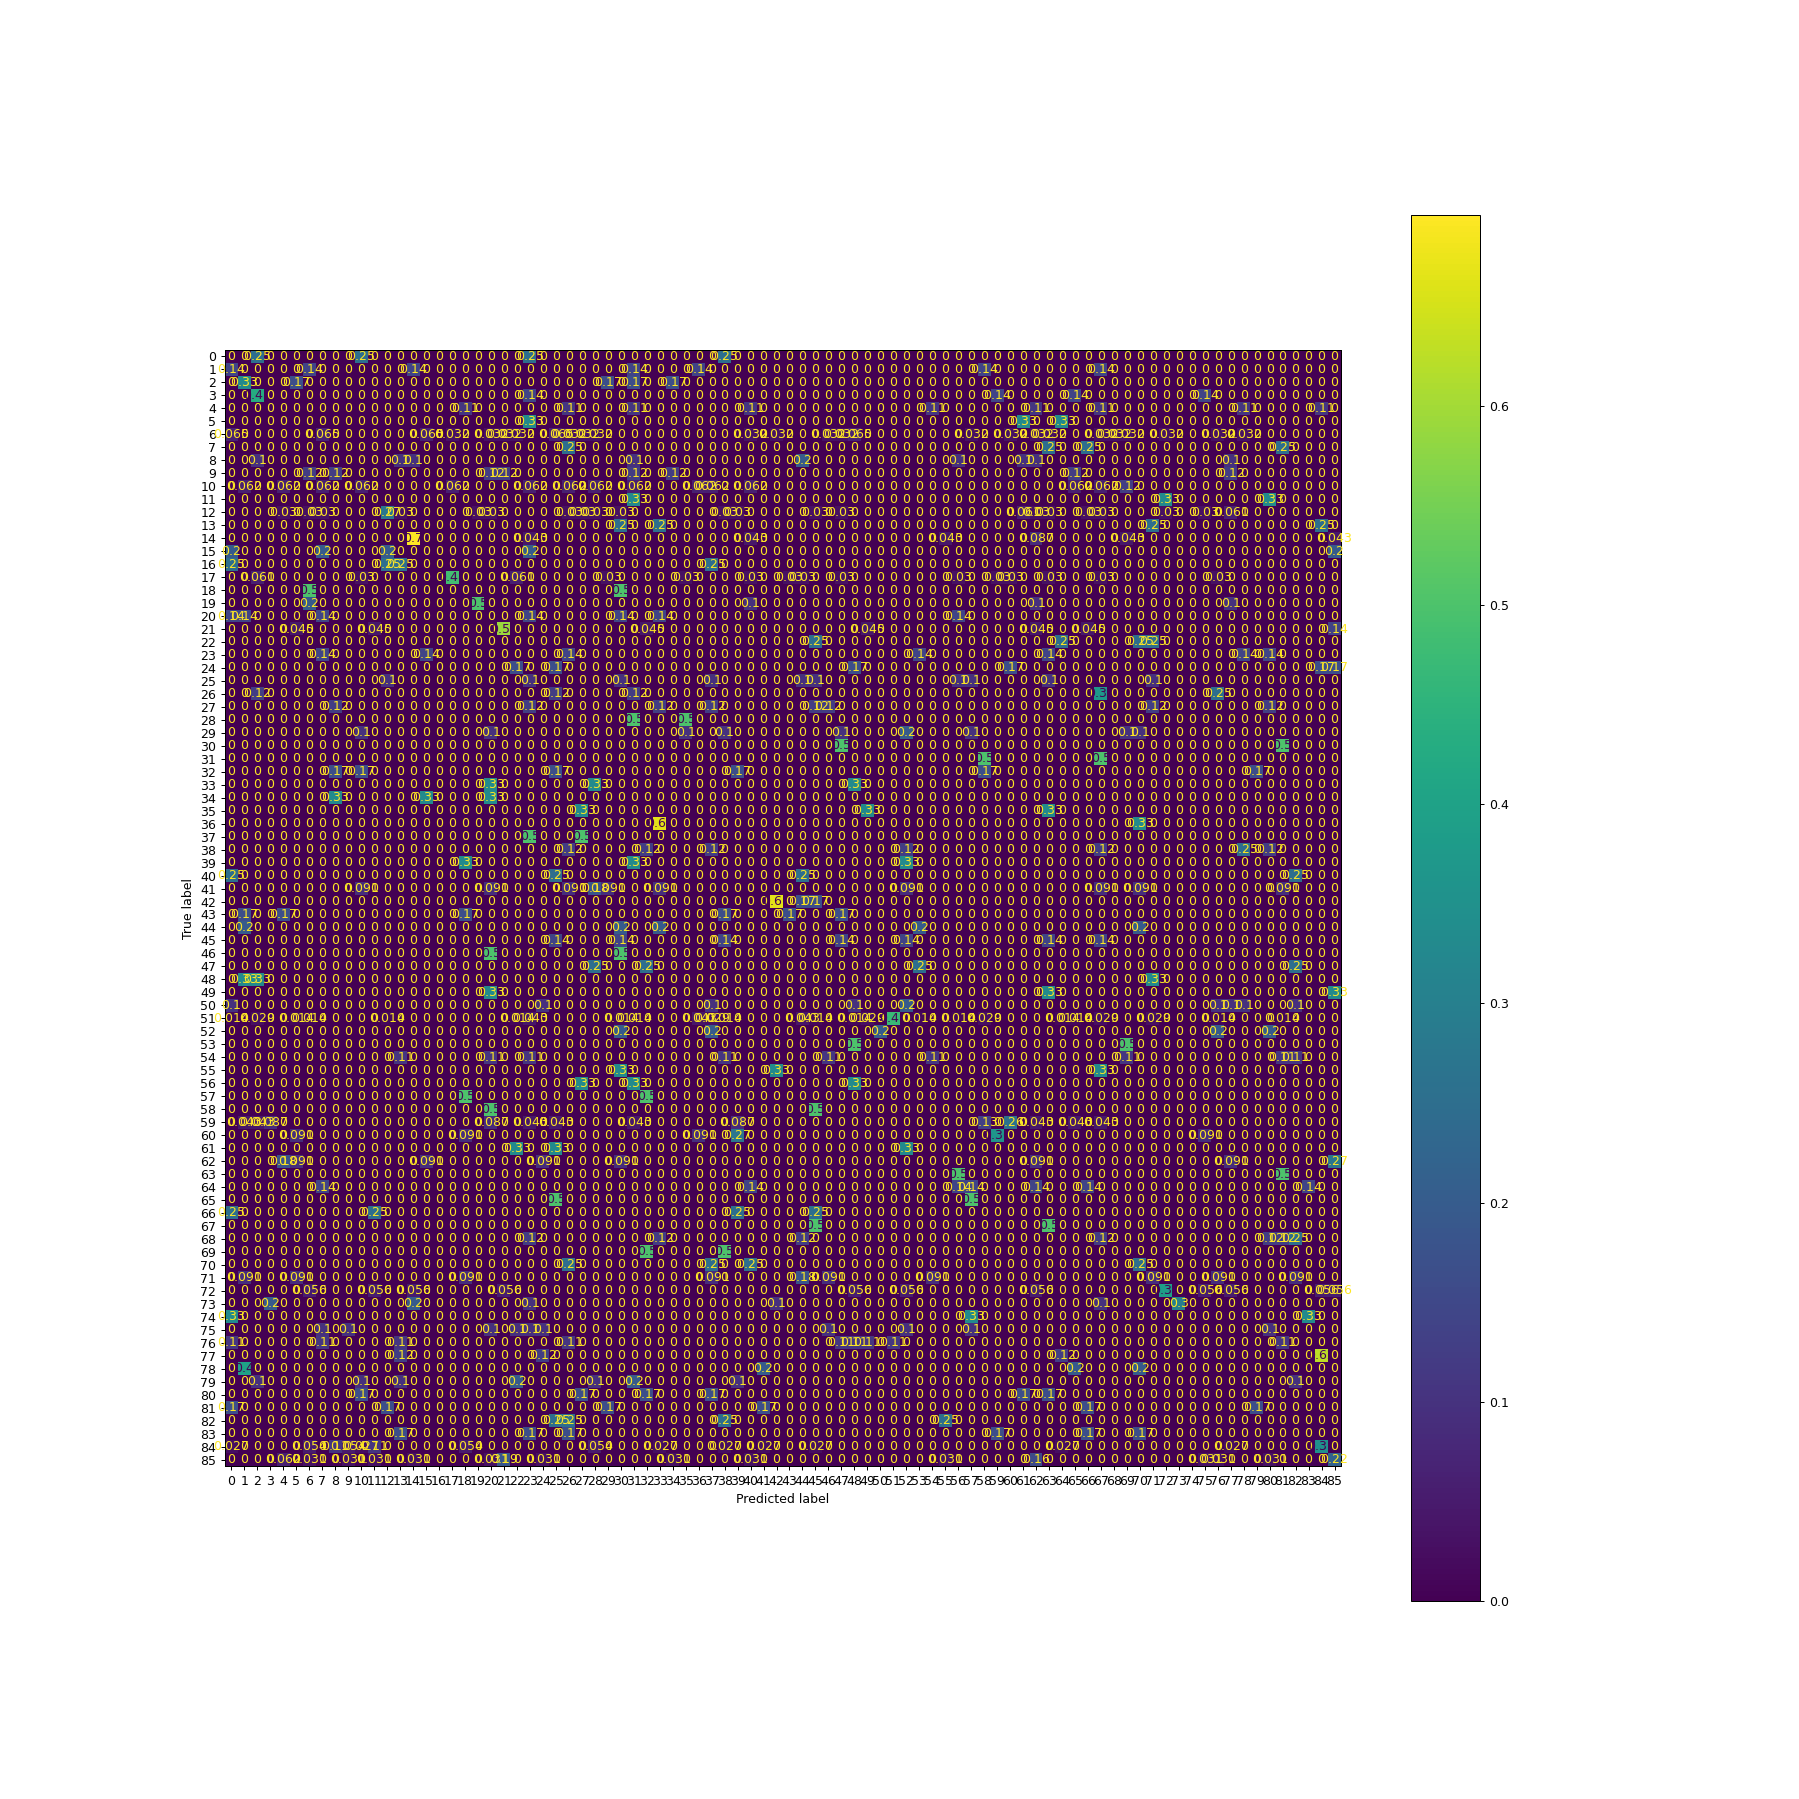

In [181]:
fi, ax = plt.subplots(1,1,figsize=(20,20))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(moa_pred_res_cca['Metadata_moa_num'],\
                      moa_pred_res_cca['Early Fusion'].values.astype(int), labels=model_tr.classes_,normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_tr.classes_)
disp.plot(ax=ax) 

### MoA clustering using each dataset and SNF data fusion

In [10]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score
from snf import compute
# logo = LeaveOneGroupOut()

# leG = preprocessing.LabelEncoder()
# group_labels=leG.fit_transform(filteredMOAs['Compounds'].values)


moa_pred_res_snf=pd.DataFrame(columns=['Data','Modality','NMI'])
# n_rand_moaClass=100
n_rand_moaClass=40
for i in range(20):
    print(i)
    listOfSelectedMoAs2=np.random.choice(merged_scaled[moa_col].unique(),n_rand_moaClass)
    IDs4filteredMOAs_2=merged_scaled[merged_scaled[moa_col].isin(listOfSelectedMoAs2)][pertColName].tolist()
    filteredMOAs_2=merged_scaled[merged_scaled[pertColName].isin(IDs4filteredMOAs_2)].reset_index(drop=True)
    snfInput=[filteredMOAs_2[cp_features].values,filteredMOAs_2[l1k_features].values]
    affinities = compute.make_affinity(snfInput, metric='euclidean')
    fused = compute.snf(affinities)
    
    labels=filteredMOAs_2[moa_col].tolist()

    le_2 = preprocessing.LabelEncoder()
    labels_categorical_2=filteredMOAs_2[moa_col].unique().tolist();
    le_2.fit(labels_categorical_2)
    labels_numerical_2=le_2.transform(labels)

    for m,d in zip(["CP","GE","fused(CP,GE)"],[affinities[0],affinities[1],fused]):
        pred_labels = spectral_clustering(d, n_clusters=n_rand_moaClass)
        nmi_snf=v_measure_score(np.random.permutation(pred_labels), labels)

        temp_df = pd.DataFrame(data={'NMI': [nmi_snf], 'Modality': [m]})
#         print(temp_df)
#         temp_df=pd.DataFrame(data=np.array([[nmi_snf],[m]]),columns=['NMI','Modality'])
#         ress_df_filt=ress_df_filt.append(temp_df)
        moa_pred_res_snf=moa_pred_res_snf.append(temp_df)
      


filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saveAsNewSheetToExistingFile(filename,moa_pred_res_snf,'fuseSNF-'+dataset+'-'+profTypeAbbrev+'-'+f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
fuseSNF-LINCS-nvs-  saved!


In [9]:
# v_measure_score(np.random.permutation(labels), labels)
i

0

In [110]:
from sklearn.cluster import spectral_clustering
from sklearn.metrics import v_measure_score, accuracy_score

pred_labels = spectral_clustering(fused, n_clusters=557)
v_measure_score(pred_labels, labels)

In [241]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(affinities[0], n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(affinities[1], n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.4547027605050385
L1k nmi:  0.5047396813615548
Fused nmi:  0.638843132270044


In [240]:
n_unq_labels=np.unique(labels_numerical_2).shape[0]
pred_labels = spectral_clustering(compute.snf([affinities[0],affinities[0]]), n_clusters=n_unq_labels)
print('CP nmi: ',v_measure_score(pred_labels, labels))
pred_labels = spectral_clustering(compute.snf([affinities[1],affinities[1]]), n_clusters=n_unq_labels)
print('L1k nmi: ',v_measure_score(pred_labels, labels))

# pred_labels = spectral_clustering(fused, n_clusters=n_unq_labels)
# print('Fused nmi: ',v_measure_score(pred_labels, labels))

CP nmi:  0.6335442415981104
L1k nmi:  0.5446253167729914


In [79]:
v_measure_score(labels_numerical_2, pred_labels)

0.782523187741443

In [76]:
# len(indexes)
indexes[1].shape

(179,)

## Visualize the results

In [12]:
filename=results_dir+'/MoAprediction/pred_moa.xlsx'
saved_scores=pd.read_excel(filename, sheet_name=None)
saved_scores.keys()

dict_keys(['fuseConcat-LINCS-nvs-filt', 'fuseCCA-LINCS-nvs-filt', 'fuseSNF-LINCS-nvs-filt', 'fuseConcat-LINCS-nvs-', 'fuseCCA-LINCS-nvs-', 'fuseSNF-LINCS-nvs-'])

In [94]:
# merged_scaled

# moa_col
DataFuseResults_filt.mean()

CP              49.603489
GE              53.687550
Early Fusion    55.511499
Late Fusion     56.225218
n_moa_cats       1.047978
dtype: float64

In [93]:
DataFuseResults_filt=saved_scores['fuseConcat-LINCS-nvs-filt'].rename(columns={'Unnamed: 0':'Compounds'})
DataFuseResults_filt=pd.merge(DataFuseResults_filt,merged_scaled[['Compounds',moa_col]],how='left',on=['Compounds'])
DataFuseResults_filt['n_moa_cats']=DataFuseResults_filt[moa_col].apply(lambda x: len(x.split('|')))
DataFuseResults_filt2=DataFuseResults_filt[DataFuseResults_filt['n_moa_cats']<2]

DataFuseResults_filt2['Data']='Filtered Samples'


DataFuseResults_all=saved_scores['fuseConcat-LINCS-nvs-']
DataFuseResults_all['Data']='All Samples'

DataFuseResults_filt_cca=saved_scores['fuseCCA-LINCS-nvs-filt']
DataFuseResults_filt_cca['Data']='Filtered Samples - CCA'

DataFuseResults_all_cca=saved_scores['fuseCCA-LINCS-nvs-']
DataFuseResults_all_cca['Data']='All Samples - CCA'

DataFuseResults_filt_snf=saved_scores['fuseSNF-LINCS-nvs-filt']
DataFuseResults_filt_snf['Data']='Filtered Samples - SNF'

DataFuseResults_all_snf=saved_scores['fuseSNF-LINCS-nvs-']
DataFuseResults_all_snf['Data']='All Samples - SNF'

<ipython-input-93-d0099a2316db>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataFuseResults_filt2['Data']='Filtered Samples'


<IPython.core.display.Javascript object>


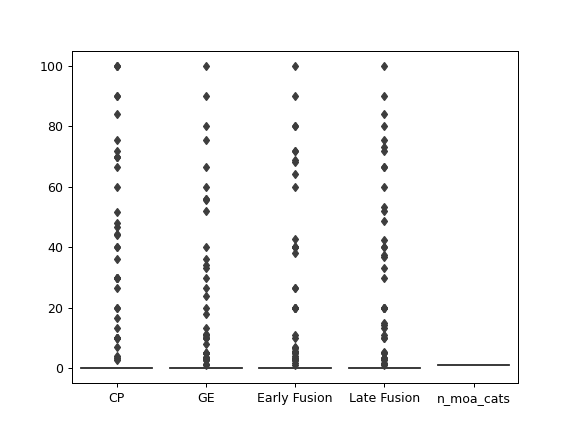

In [81]:
# merged_scaled
plt.figure()
sns.boxplot(data=DataFuseResults_filt2.groupby([moa_col]).mean())

<IPython.core.display.Javascript object>


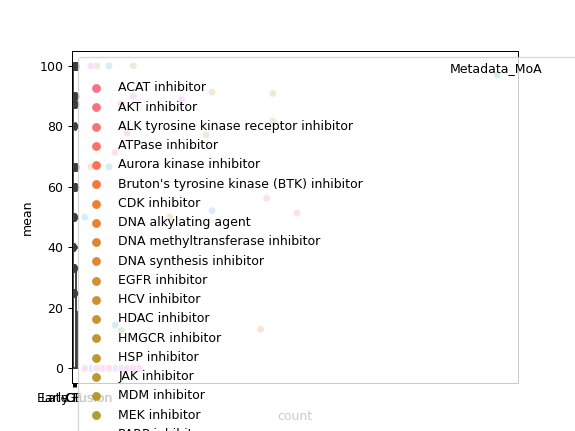

In [56]:
plt.figure()
sns.boxplot(data=DataFuseResults_filt2.groupby([moa_col]).median())

In [82]:
described_data=DataFuseResults_filt2.groupby([moa_col]).describe()

In [79]:
# plt.figure()
# sns.scatterplot(data=described_data['CP'], x="count", y="mean", hue="Metadata_MoA",legend=False)


<IPython.core.display.Javascript object>


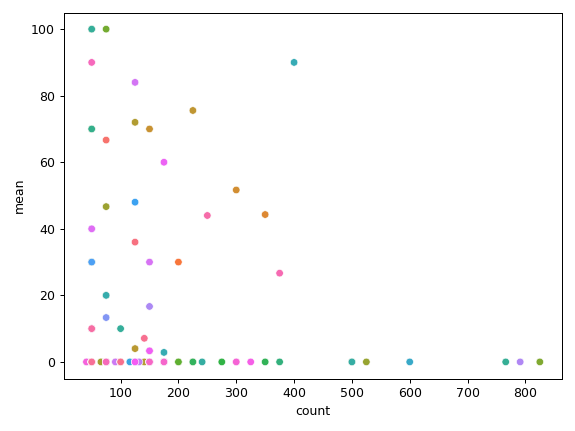

In [83]:
plt.figure()
sns.scatterplot(data=described_data['CP'], x="count", y="mean", hue="Metadata_MoA",legend=False)
plt.tight_layout()# pd.merge(DataFuseResults_filt,merged_scaled[['Compounds',moa_col]],how='left',on=['Compounds'])

In [36]:
# pd.melt(DataFuseResults_filt)#.rename(columns={'variable':'lmGens','value':'pred score'})
# plt.figure()
sns.boxplot(data=DataFuseResults_all_snf)
# merged_scaled[['PERT',moa_col]]

,PERT,Metadata_MoA
0,BRD-A00147595_0.04,insulin sensitizer|PPAR receptor partial agonist
1,BRD-A00147595_0.12,insulin sensitizer|PPAR receptor partial agonist
2,BRD-A00147595_0.37,insulin sensitizer|PPAR receptor partial agonist
3,BRD-A00147595_1.11,insulin sensitizer|PPAR receptor partial agonist
4,BRD-A00147595_3.33,insulin sensitizer|PPAR receptor partial agonist
...,...,...
6980,BRD-M89827113_0.12,potassium channel activator
6981,BRD-M89827113_0.37,potassium channel activator
6982,BRD-M89827113_1.11,potassium channel activator
6983,BRD-M89827113_3.33,potassium channel activator


In [27]:
# DataFuseResults_all_snf

In [24]:
DataFuseResults_filt_cca.describe()

,CP,GE,Early Fusion,Late Fusion
count,752.000000,752.000000,752.000000,752.000000
mean,23.936170,12.500000,19.148936,19.281915
std,36.593439,22.141257,30.360798,30.029847
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,40.000000,20.000000,40.000000,40.000000
max,100.000000,100.000000,100.000000,100.000000


In [ ]:
# DataFuseResults=DataFuseResults_loaded.copy()
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

fig, axes = plt.subplots(1,4,figsize=(10,5))
sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            palette="Set1",ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,20)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            palette="Set1",ax=axes[1])
axes[1].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[1].set_ylim(0,70)
axes[1].set_title('(b)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            hue_order=['CP','GE','CP+GE'],palette="Set1",ax=axes[2])
axes[2].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[2].set_ylim(0,20)
axes[2].set_title('(c)');

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="Set1",ax=axes[3])
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[3].set_ylim(10,100)
axes[3].set_title('(d)');
fig.tight_layout()

In [ ]:
sns.boxplot(data=df)

In [ ]:
import matplotlib.style as style
style.use('seaborn-colorblind')
DataFuseResults=DataFuseResults.rename(columns={'acc':'Accuracy'})

hfont = {'fontname':'sans-serif'}

# plt.title('title',**csfont)

fig, axes = plt.subplots(1,3,figsize=(9,6))
fig.suptitle('MoA Classification', fontsize=15,**hfont)

sns.set_context("paper")
sns.set_style("whitegrid")
# sns.rcParams['patch.force_edgecolor'] = True
# for d in range(5):#(len(datasets)):
sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples'],\
            ax=axes[0])
axes[0].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[0].set_ylim(0,30)
axes[0].set_title('(a)');

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='Filtered Samples'],\
            ax=axes[2])
axes[2].axhline(y=(1/179)*100,linestyle=':',color='r');
axes[2].set_ylim(0,100)
axes[2].set_title('(c)');
axes[2].set(ylabel=None)

sns.boxplot(x="Data", y="Accuracy", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - CCA'],\
            ax=axes[1])
# hue_order=['CP','GE','CP+GE']
axes[1].axhline(y=(1/557)*100,linestyle=':',color='r');
axes[1].set_ylim(0,30)
axes[1].set_title('(b)');
axes[1].set(ylabel=None)

# sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
#             palette="cividis",ax=axes[3])
# # axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
# axes[3].set_ylim(0,100)
# axes[3].set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clussif.eps')

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(2.5,6))
fig.suptitle('MoA Clustering', fontsize=15,**hfont)

sns.boxplot(x="Data", y="NMI", hue="Modality",data=DataFuseResults[DataFuseResults['Data']=='All Samples - SNF'],\
            palette="cividis",ax=axes)
# axes[3].axhline(y=(1/557)*100,linestyle=':',color='r');
axes.set_ylim(0,100)
axes.set_title('(d)');
# fig.tight_layout()
fig.savefig('moa_clustering.eps',bbox_inches='tight')